In [ ]:
# @title 1. Kütüphanelerin Yüklenmesi
!pip install lpips einops kornia bchlib easydict pyyaml pytorch-msssim

import os
import torch
import torch.nn as nn
import numpy as np
import bchlib
from PIL import Image, ImageOps #goruntu acmak, rgb'ye cevirmek vb. icin
import torchvision.transforms as transforms #goruntuyu tensore cevirmek, normalize etmek icin
import matplotlib.pyplot as plt
import cv2 #gurultu ekleme, kirpma, dondurme icin
import lpips #metrik, insan gozune uygun bozulma olcumu
from pytorch_msssim import ms_ssim # metrik, goruntu ne kadar korundu olcmek icin


In [ ]:
# Proje klasörlerini oluşturuyoruz
os.makedirs("cfg", exist_ok=True)
os.makedirs("saved_models/masktrain", exist_ok=True)
os.makedirs("Output/stego", exist_ok=True)
os.makedirs("Output/resdiual", exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #donanim uyumlulugu
print(f"Kütüphaneler yüklendi. Kullanılan cihaz: {device}")

Kütüphaneler yüklendi. Kullanılan cihaz: cuda


In [ ]:
# @title 2. Model Dosyalarını Oluşturma (ViT, Encoder, Decoder)

# 1. vit.py
code_vit = """
import torch
import torch.nn as nn
import numpy as np
from einops import rearrange, repeat

class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, head_num):
        super().__init__()
        self.head_num = head_num
        self.dk = (embedding_dim // head_num) ** (1 / 2)
        self.qkv_layer = nn.Linear(embedding_dim, embedding_dim * 3, bias=False)
        self.out_attention = nn.Linear(embedding_dim, embedding_dim, bias=False)

    def forward(self, x, mask=None):
        qkv = self.qkv_layer(x)
        query, key, value = tuple(rearrange(qkv, 'b t (d k h ) -> k b h t d ', k=3, h=self.head_num))
        energy = torch.einsum("... i d , ... j d -> ... i j", query, key) * self.dk
        if mask is not None:
            energy = energy.masked_fill(mask, -np.inf)
        attention = torch.softmax(energy, dim=-1)
        x = torch.einsum("... i j , ... j d -> ... i d", attention, value)
        x = rearrange(x, "b h t d -> b t (h d)")
        x = self.out_attention(x)
        return x

class MLP(nn.Module):
    def __init__(self, embedding_dim, mlp_dim):
        super().__init__()
        self.mlp_layers = nn.Sequential(
            nn.Linear(embedding_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(mlp_dim, embedding_dim),
            nn.Dropout(0.1)
        )
    def forward(self, x):
        x = self.mlp_layers(x)
        return x

class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim, head_num, mlp_dim):
        super().__init__()
        self.multi_head_attention = MultiHeadAttention(embedding_dim, head_num)
        self.mlp = MLP(embedding_dim, mlp_dim)
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        _x = self.multi_head_attention(x)
        _x = self.dropout(_x)
        x = x + _x
        x = self.layer_norm1(x)
        _x = self.mlp(x)
        x = x + _x
        x = self.layer_norm2(x)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, head_num, mlp_dim, block_num=12):
        super().__init__()
        self.layer_blocks = nn.ModuleList(
            [TransformerEncoderBlock(embedding_dim, head_num, mlp_dim) for _ in range(block_num)])
    def forward(self, x):
        for layer_block in self.layer_blocks:
            x = layer_block(x)
        return x

class ViT(nn.Module):
    def __init__(self, img_dim, in_channels, embedding_dim, head_num, mlp_dim,
                 block_num, patch_dim, classification=True, num_classes=1):
        super().__init__()
        self.patch_dim = patch_dim
        self.classification = classification
        self.num_tokens = (img_dim // patch_dim) ** 2
        self.token_dim = in_channels * (patch_dim ** 2)
        self.projection = nn.Linear(self.token_dim, embedding_dim)
        self.embedding = nn.Parameter(torch.rand(self.num_tokens + 1, embedding_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.dropout = nn.Dropout(0.1)
        self.transformer = TransformerEncoder(embedding_dim, head_num, mlp_dim, block_num)
        if self.classification:
            self.mlp_head = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        img_patches = rearrange(x,
                                'b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)',
                                patch_x=self.patch_dim, patch_y=self.patch_dim)
        batch_size, tokens, _ = img_patches.shape
        project = self.projection(img_patches)
        token = repeat(self.cls_token, 'b ... -> (b batch_size) ...',
                       batch_size=batch_size)
        patches = torch.cat([token, project], dim=1)
        patches += self.embedding[:tokens + 1, :]
        x = self.dropout(patches)
        x = self.transformer(x)
        x = self.mlp_head(x[:, 0, :]) if self.classification else x[:, 1:, :]
        return x
"""
with open("vit.py", "w") as f:
    f.write(code_vit)

# 2. Encoder.py
code_encoder = """
import torch
import torch.nn as nn
from einops import rearrange
from vit import ViT

class Dense(nn.Module):
    def __init__(self, in_features, out_features, activation='relu', kernel_initializer='he_normal'):
        super(Dense, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        if kernel_initializer == 'he_normal':
            nn.init.kaiming_normal_(self.linear.weight)
        self.activation = activation

    def forward(self, inputs):
        outputs = self.linear(inputs)
        if self.activation == 'relu':
            outputs = nn.ReLU(inplace=True)(outputs)
        return outputs

class EncoderBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, base_width=64):
        super().__init__()
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        width = int(out_channels * (base_width / 64))
        self.conv1 = nn.Conv2d(in_channels, width, kernel_size=1, stride=1, bias=False)
        self.norm1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=2, groups=1, padding=1, dilation=1, bias=False)
        self.norm2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, out_channels, kernel_size=1, stride=1, bias=False)
        self.norm3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x_down = self.downsample(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = x + x_down
        x = self.relu(x)
        return x

class DecoderBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=True)
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, x_concat=None):
        x = self.upsample(x)
        if x_concat is not None:
            x = torch.cat([x_concat, x], dim=1)
        x = self.layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, img_dim, in_channels, out_channels, head_num, mlp_dim, block_num, patch_dim):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels, in_channels, kernel_size=7, stride=1, padding=3, bias=False)
        self.norm0 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels * 2, out_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.relu0 = nn.ReLU(inplace=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.encoder1 = EncoderBottleneck(out_channels, out_channels * 2, stride=2)
        self.encoder2 = EncoderBottleneck(out_channels * 2, out_channels * 4, stride=2)
        self.encoder3 = EncoderBottleneck(out_channels * 4, out_channels * 8, stride=2)
        self.vit_img_dim = img_dim // patch_dim
        self.vit = ViT(self.vit_img_dim, out_channels * 8, out_channels * 8,
                       head_num, mlp_dim, block_num, patch_dim=1, classification=False)
        self.conv2 = nn.Conv2d(out_channels * 8, out_channels * 4, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(out_channels * 4)

    def forward(self, x, secret):
        x = self.conv0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        x = torch.cat([x, secret], dim=1)
        x = self.conv1(x)
        x = self.norm1(x)
        x1 = self.relu1(x)
        x2 = self.encoder1(x1)
        x3 = self.encoder2(x2)
        x = self.encoder3(x3)
        x = self.vit(x)
        x = rearrange(x, "b (x y) c -> b c x y", x=self.vit_img_dim, y=self.vit_img_dim)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        return x, x1, x2, x3

class Decoder(nn.Module):
    def __init__(self, out_channels, class_num):
        super().__init__()
        self.decoder1 = DecoderBottleneck(out_channels * 8, out_channels * 2)
        self.decoder2 = DecoderBottleneck(out_channels * 4, out_channels)
        self.decoder3 = DecoderBottleneck(out_channels * 2, int(out_channels * 1 / 2))
        self.decoder4 = DecoderBottleneck(int(out_channels * 1 / 2), int(out_channels * 1 / 8))
        self.conv1 = nn.Conv2d(int(out_channels * 1 / 8), class_num, kernel_size=1)

    def forward(self, x, x1, x2, x3):
        x = self.decoder1(x, x3)
        x = self.decoder2(x, x2)
        x = self.decoder3(x, x1)
        x = self.decoder4(x)
        x = self.conv1(x)
        return x

class TransUNet(nn.Module):
    def __init__(self, img_dim, in_channels, out_channels, head_num, mlp_dim, block_num, patch_dim, class_num):
        super().__init__()
        self.secret_dense = Dense(100, 7500, activation='relu', kernel_initializer='he_normal')
        self.encoder = Encoder(img_dim, in_channels, out_channels,
                               head_num, mlp_dim, block_num, patch_dim)
        self.decoder = Decoder(out_channels, class_num)

    def forward(self, inputs):
        secrect, image = inputs
        secrect = secrect - .5
        image = image - .5
        secrect = self.secret_dense(secrect)
        secrect = secrect.reshape(-1, 3, 50, 50)
        secrect_enlarged = nn.Upsample(scale_factor=(8, 8))(secrect)
        x, x1, x2, x3 = self.encoder(image, secrect_enlarged)
        x = self.decoder(x, x1, x2, x3)
        return x
"""
with open("Encoder.py", "w") as f:
    f.write(code_encoder)

# 3. decode_image.py
code_decode = """
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np

class Dense(nn.Module):
    def __init__(self, in_features, out_features, activation='relu', kernel_initializer='he_normal'):
        super(Dense, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        if kernel_initializer == 'he_normal':
            nn.init.kaiming_normal_(self.linear.weight)
        self.activation = activation
    def forward(self, inputs):
        outputs = self.linear(inputs)
        if self.activation == 'relu':
            outputs = nn.ReLU(inplace=True)(outputs)
        return outputs

class Conv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, activation='relu', strides=1, padding=0):
        super(Conv2D, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, strides, int((kernel_size - 1) / 2))
        nn.init.kaiming_normal_(self.conv.weight)
        self.activation = activation
    def forward(self, inputs):
        outputs = self.conv(inputs)
        if self.activation == 'relu':
            outputs = nn.ReLU(inplace=True)(outputs)
        return outputs

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, input):
        return input.view(input.size(0), -1)

class SpatialTransformerNetwork(nn.Module):
    def __init__(self):
        super(SpatialTransformerNetwork, self).__init__()
        self.localization = nn.Sequential(
            Conv2D(3, 32, 3, strides=2, activation='relu'),
            Conv2D(32, 64, 3, strides=2, activation='relu'),
            Conv2D(64, 128, 3, strides=2, activation='relu'),
            Flatten(),
            Dense(320000, 128, activation='relu'),
            nn.Linear(128, 6)
        )
        self.localization[-1].weight.data.fill_(0)
        self.localization[-1].bias.data = torch.FloatTensor([1, 0, 0, 0, 1, 0])

    def forward(self, image):
        theta = self.localization(image)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, image.size(), align_corners=False)
        transformed_image = F.grid_sample(image, grid, align_corners=False)
        return transformed_image

class Decoder(nn.Module):
    def __init__(self, secret_size=100):
        super(Decoder, self).__init__()
        self.secret_size = secret_size
        self.stn = SpatialTransformerNetwork()
        self.decoder = nn.Sequential(
            Conv2D(3, 48, 1, activation='relu'),
            Conv2D(48, 48, 3, activation='relu'),
            Conv2D(48, 48, 3, activation='relu'),
            Conv2D(48, 48, 1, activation='relu'),
            Conv2D(48, 48, 3, activation='relu'),
            Conv2D(48, 48, 3, activation='relu'),
            Conv2D(48, 24, 1, activation='relu'),
            Conv2D(24, 24, 3, activation='relu'),
            Conv2D(24, 24, 3, activation='relu'),
            Conv2D(24, 1, 1, activation='relu'),
            Flatten(),
            Dense(160000, secret_size, activation=None)
            )

    def forward(self, image):
        image = image - .5
        transformed_image = self.stn(image)
        return torch.sigmoid(self.decoder(transformed_image))
"""
with open("decode_image.py", "w") as f:
    f.write(code_decode)

print("ViT, Encoder, Decode_Image model dosyaları oluşturuldu.")

Tüm model dosyaları oluşturuldu.


In [ ]:
# @title 3. Modelleri Yükleme ve Fonksiyonları Tanımlama
import Encoder as transmodel
import decode_image

# --- FONKSIYONLAR ---
def str_to_bits(s, total_bits=100): #mesaji bit dizisine cevir (sabit uzunlukta)
    bits = []
    for char in s:
        bin_val = bin(ord(char))[2:].zfill(8)
        bits.extend([int(b) for b in bin_val])
    if len(bits) < total_bits:
        bits.extend([0] * (total_bits - len(bits)))
    else:
        bits = bits[:total_bits]
    return bits

def bits_to_str(bits): #bit dizisini mesaja cevir
    chars = []
    for i in range(0, len(bits), 8):
        byte = bits[i:i+8]
        if len(byte) < 8: break
        char_val = int("".join(map(str, byte)), 2)
        if char_val == 0: break
        chars.append(chr(char_val))
    return "".join(chars)

def calculate_accuracy(secret_bits, decoded_bits): #bit accuracy
    correct = sum([1 for i, j in zip(secret_bits, decoded_bits) if i == j])
    return (correct / len(secret_bits)) * 100

def encode_message(secret, encoder, image_tensor):
    secret_bits = str_to_bits(secret)
    secret_tensor = torch.tensor(secret_bits, dtype=torch.float).unsqueeze(0).to(device)
    residual = encoder((secret_tensor, image_tensor))
    encoded_image = image_tensor + residual
    return encoded_image.clamp(0, 1), secret_tensor, secret_bits

def decode_message_from_tensor(decoder, image_tensor):
    secret_pred = decoder(image_tensor)
    secret_pred = secret_pred.cpu().detach().numpy()[0]
    secret_bits = np.round(secret_pred).astype(int).tolist()
    try:
        code = bits_to_str(secret_bits)
        return code, secret_bits
    except:
        return "Çözülemedi", secret_bits

def prepare_image(image_path, size=(400, 400)): #Görüntüyü PyTorch modeline uygun hale getirir.
    image = Image.open(image_path).convert("RGB")
    image = ImageOps.fit(image, size)
    to_tensor = transforms.ToTensor()
    image_tensor = to_tensor(image).unsqueeze(0).to(device)
    return image, image_tensor

In [ ]:
#Model .pth dosyalarini indirme
import Encoder as transmodel

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

paths = {
    'encoder': 'saved_models/masktrain/en_name.pth',
    'decoder': 'saved_models/masktrain/de_name.pth'
}

print("Dosya boyutları kontrol ediliyor...")
for key, path in paths.items():
    if os.path.exists(path):
        size = os.path.getsize(path)
        print(f"{path}: {size} bytes")
        if size < 5000: #kontrol
            print(f"UYARI: {path} gerçek model dosyası değil (Git LFS pointer). Siliniyor...")
            os.remove(path)
    else:
        print(f"{path} zaten yok.")

os.makedirs('saved_models/masktrain', exist_ok=True)

print("\nGerçek model dosyaları indiriliyor...")
if not os.path.exists(paths['encoder']): #raw indir eger yoksa
    !wget -q https://github.com/Supersirui/TransStego/raw/main/saved_models/masktrain/en_name.pth -O saved_models/masktrain/en_name.pth
    print("Encoder indirildi.")

if not os.path.exists(paths['decoder']):#raw indir eger yoksa
    !wget -q https://github.com/Supersirui/TransStego/raw/main/saved_models/masktrain/de_name.pth -O saved_models/masktrain/de_name.pth
    print("Decoder indirildi.")

print("İndirme tamamlandı.\n")


print("Modeller belleğe yükleniyor...")
#model mimarisi ayarlama(goruntu boyutu, rgb, residual kanal sayisi,OdaklancakSey(renkDokuVb.) noron sayi, derinlik, patch(bolum) sayisi, cikti kanal sayisi )
encoder = transmodel.TransUNet(img_dim=400, in_channels=3, out_channels=192, head_num=4, mlp_dim=512, block_num=8, patch_dim=16, class_num=3).to(device) #modeli cuda'ya yukle
encoder.load_state_dict(torch.load(paths['encoder'], map_location=device, weights_only=False))
encoder.eval()

decoder = decode_image.Decoder(secret_size=100).to(device)

decoder.load_state_dict(torch.load(paths['decoder'], map_location=device, weights_only=False))
decoder.eval()

lpips_fn = lpips.LPIPS(net='alex').to(device)

print("\nBAŞARILI: Modeller gerçek dosyalarla hatasız yüklendi!")

Dosya boyutları kontrol ediliyor...
saved_models/masktrain/en_name.pth: 583102108 bytes
saved_models/masktrain/de_name.pth: 228617206 bytes

Gerçek model dosyaları indiriliyor...
İndirme tamamlandı.

Modeller belleğe yükleniyor...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth

BAŞARILI: Modeller gerçek dosyalarla hatasız yüklendi!


UYGULAMA

In [ ]:
# @title 4. Ana İşlem Fonksiyonunu
import torchvision.transforms.functional as TF #tensor seviyesinde goruntu donusumu, donusum hatas az olsun diye

# --- Saldırı Fonksiyonları ---
def attack_crop(img_tensor, scale=0.8):
    _, _, h, w = img_tensor.shape
    new_h, new_w = int(h*scale), int(w*scale)
    cropper = transforms.CenterCrop((new_h, new_w))
    resizer = transforms.Resize((h, w))
    return resizer(cropper(img_tensor))

def attack_noise(img_tensor, std=0.05):
    noise = torch.randn_like(img_tensor) * std
    return (img_tensor + noise).clamp(0, 1)

def attack_rotation(img_tensor, angle=10):
    return TF.rotate(img_tensor, angle)

# --- Karakter Doğruluğu Hesaplama Fonksiyonu---
def calculate_char_accuracy(original_msg, decoded_msg):
    if not decoded_msg or len(original_msg) == 0: return 0.0
    match_count = 0
    limit = min(len(original_msg), len(decoded_msg))
    for i in range(limit):
        if original_msg[i] == decoded_msg[i]: match_count += 1
    return (match_count / len(original_msg)) * 100

# --- ANA FONKSİYON (RS'siz)---
def run_steganography_pipeline(image_path, secret_message, encoder, decoder, lpips_fn, attack_params=None):
    print(f"İşleme Alınan Görsel: {image_path}")

    params = {'noise_std': 0.05, 'crop_scale': 0.8, 'rot_angle': 10}
    if attack_params: params.update(attack_params)

    # 1. Resim Al
    if not os.path.exists(image_path):
        print(f"HATA: {image_path} bulunamadı!")
        return
    original_pil, original_tensor = prepare_image(image_path) #goruntuyu model calismasi icin tensore donustur

    # 2. Gizleme
    stego_tensor, secret_tensor_in, secret_bits_in = encode_message(secret_message, encoder, original_tensor)
    #GizliMesajliResim, Gpu'ya hazir veri, Gizli veri ham hali
    print(f"Mesaj Gizlendi\n")

    # 3. Metrikler
    mse = torch.mean((original_tensor - stego_tensor) ** 2).item()
    psnr = 20 * np.log10(1.0 / np.sqrt(mse))
    lpips_val = lpips_fn(original_tensor*2-1, stego_tensor*2-1).item()

    # Doğruluk
    decoded_msg_clean, decoded_bits_clean = decode_message_from_tensor(decoder, stego_tensor)
    bit_acc_clean = calculate_accuracy(secret_bits_in, decoded_bits_clean)
    msg_acc_clean = calculate_char_accuracy(secret_message, decoded_msg_clean)

    print(f"--- Kalite Metrikleri ---\nPSNR: {psnr:.2f} | LPIPS: {lpips_val:.4f} | MSE: {mse:.4f}")
    print(f"TEMİZ ÇÖZME -> Bit Acc: %{bit_acc_clean:.1f} | Msg Acc: %{msg_acc_clean:.1f} | Mesaj: {decoded_msg_clean}\n")

    # --- 4.GÖRSELLEŞTİRME---

    # Farkı hesapla
    diff_tensor = torch.abs(original_tensor - stego_tensor)

    if diff_tensor.max() > 0:
        diff_normalized = diff_tensor / diff_tensor.max()
    else:
        diff_normalized = diff_tensor

    original_np = original_tensor.squeeze().cpu().permute(1, 2, 0).detach().numpy()
    stego_np = stego_tensor.squeeze().cpu().permute(1, 2, 0).detach().numpy()
    diff_np = diff_normalized.squeeze().cpu().permute(1, 2, 0).detach().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].imshow(original_np)
    ax[0].set_title("Orijinal")
    ax[0].axis('off')

    ax[1].imshow(stego_np)
    ax[1].set_title(f"Stego\nPSNR: {psnr:.2f}")
    ax[1].axis('off')

    ax[2].imshow(diff_np)
    ax[2].set_title("İki Resim Farkı \n")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

    # 5. Dayanıklılık Testleri
    print(f"\n--- Dayanıklılık Testleri (Parametreler: {params}) ---")

    noise_img = attack_noise(stego_tensor, std=params['noise_std'])
    crop_img = attack_crop(stego_tensor, scale=params['crop_scale'])
    rot_img = attack_rotation(stego_tensor, angle=params['rot_angle'])

    dec_noise, bits_noise = decode_message_from_tensor(decoder, noise_img)
    dec_crop, bits_crop = decode_message_from_tensor(decoder, crop_img)
    dec_rot, bits_rot = decode_message_from_tensor(decoder, rot_img)

    bit_acc_noise = calculate_accuracy(secret_bits_in, bits_noise)
    msg_acc_noise = calculate_char_accuracy(secret_message, dec_noise)

    bit_acc_crop = calculate_accuracy(secret_bits_in, bits_crop)
    msg_acc_crop = calculate_char_accuracy(secret_message, dec_crop)

    bit_acc_rot = calculate_accuracy(secret_bits_in, bits_rot)
    msg_acc_rot = calculate_char_accuracy(secret_message, dec_rot)

    print(f"Gürültü -> Bit Acc: %{bit_acc_noise:.1f} | Msg Acc: %{msg_acc_noise:.1f} | Mesaj: {dec_noise}")
    print(f"Kırpma  -> Bit Acc: %{bit_acc_crop:.1f} | Msg Acc: %{msg_acc_crop:.1f} | Mesaj: {dec_crop}")
    print(f"Döndürme-> Bit Acc: %{bit_acc_rot:.1f} | Msg Acc: %{msg_acc_rot:.1f} | Mesaj: {dec_rot}")

    # Saldırı Görüntüleri
    fig2, ax2 = plt.subplots(1, 3, figsize=(14, 5))

    noise_np = noise_img.squeeze().cpu().permute(1, 2, 0).detach().numpy()
    crop_np = crop_img.squeeze().cpu().permute(1, 2, 0).detach().numpy()
    rot_np = rot_img.squeeze().cpu().permute(1, 2, 0).detach().numpy()

    ax2[0].imshow(noise_np); ax2[0].set_title(f"Gürültü"); ax2[0].axis('off')
    ax2[1].imshow(crop_np); ax2[1].set_title(f"Kırpma"); ax2[1].axis('off')
    ax2[2].imshow(rot_np); ax2[2].set_title(f"Döndürme"); ax2[2].axis('off')

    plt.tight_layout()
    plt.show()

İşleme Alınan Görsel: takim.jpg
Mesaj Gizlendi

--- Kalite Metrikleri ---
PSNR: 35.26 | LPIPS: 0.0046 | MSE: 0.0003
TEMİZ ÇÖZME -> Bit Acc: %100.0 | Msg Acc: %2.5 | Mesaj: Makale uzun 



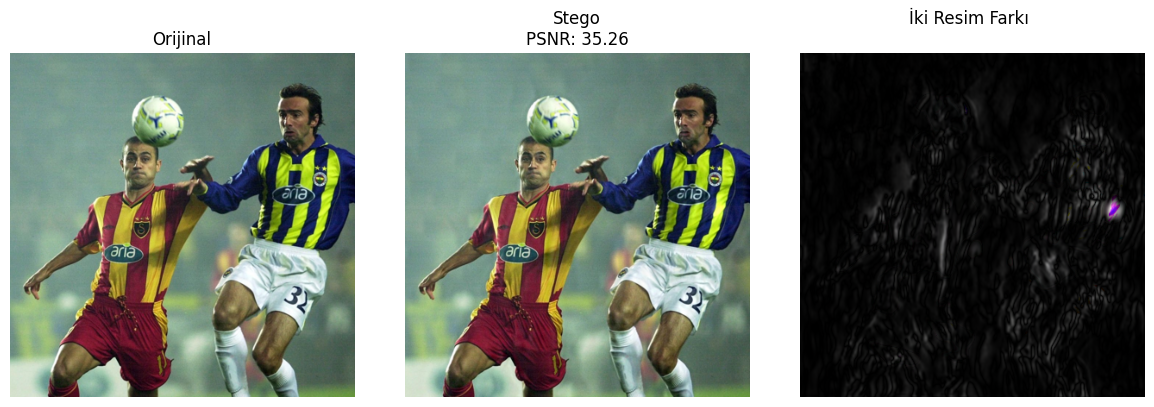


--- Dayanıklılık Testleri (Parametreler: {'noise_std': 0.08, 'crop_scale': 0.95, 'rot_angle': 4}) ---
Gürültü -> Bit Acc: %98.0 | Msg Acc: %2.1 | Mesaj: Makade uzul 
Kırpma  -> Bit Acc: %99.0 | Msg Acc: %2.3 | Mesaj: Makala uzun 
Döndürme-> Bit Acc: %100.0 | Msg Acc: %2.5 | Mesaj: Makale uzun 


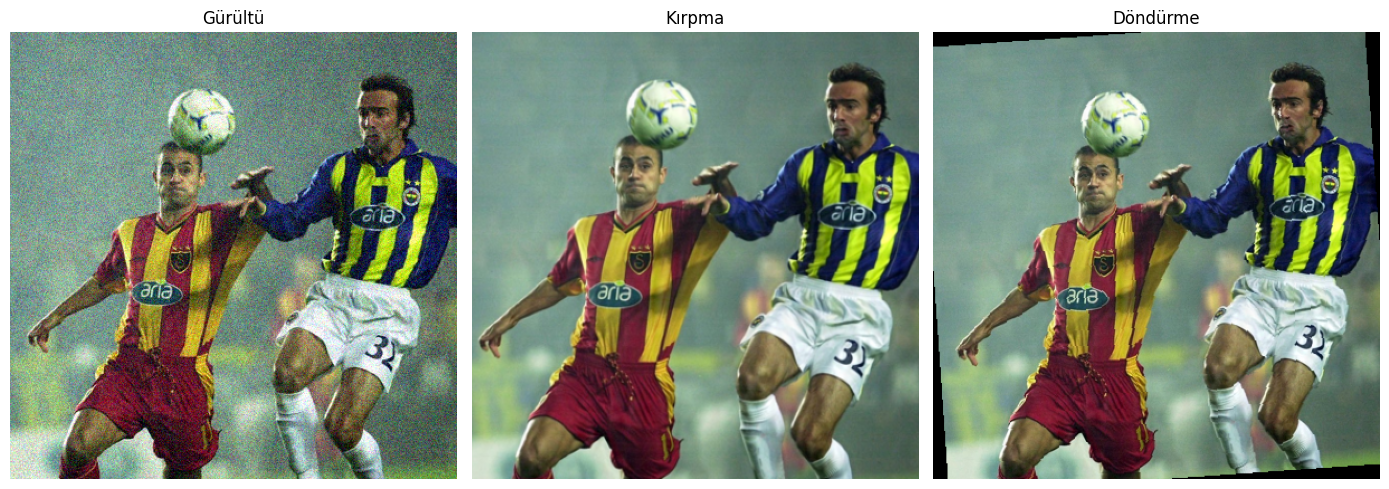

In [ ]:
# @title 5. MAIN ÇALIŞTIRMA

IMAGE_FILE = "takim.jpg"
MESSAGE =                                                                                     "https://colab.research.google.com/drive/1ZQxFjUY-m6C_LQ9bA3IeV9hlDbwPWneg#scrollTo=TPqfmQgpwuac"

# --- SALDIRI AYARLARI ---
attack_variables = {
    'noise_std': 0.08,
    'crop_scale': 0.95,
    'rot_angle': 4
}

# İşlem Başlat
run_steganography_pipeline(
    IMAGE_FILE,
    MESSAGE,
    encoder,
    decoder,
    lpips_fn,
    attack_params=attack_variables
)

In [ ]:
# @title 6. Reed-Solomon (Hata Düzeltme) Modülü ile Saldırı Dayanıklılığı Ölçme
!pip install reedsolo -q

import reedsolo
from reedsolo import RSCodec, ReedSolomonError

ECC_BYTES = 6
MAX_DATA_CAPACITY = 12 - ECC_BYTES

print(f"Reed-Solomon Modülü Başlatıldı.")
print(f"-> ECC Boyutu: {ECC_BYTES} byte")
print(f"-> Mesaj Kapasitesi: {MAX_DATA_CAPACITY} karakter")

rsc = RSCodec(ECC_BYTES)

def encode_message_with_rs(secret_message):
    # 1. Kapasite Kontrolü ve Kırpma
    if len(secret_message) > MAX_DATA_CAPACITY:
        print(f"UYARI: Mesaj ({len(secret_message)} kar.) kapasiteyi aşıyor. İlk {MAX_DATA_CAPACITY} kar. alındı.")
        secret_message = secret_message[:MAX_DATA_CAPACITY]
    elif len(secret_message) < MAX_DATA_CAPACITY:
        # Padding (Boşlukla tamamlama) - RS için önemli
        secret_message = secret_message + ' ' * (MAX_DATA_CAPACITY - len(secret_message))

    # 2. Kodlama (Encode)
    # Metni byte'a çevir
    data = bytearray(secret_message, 'utf-8')

    # RS Kodlaması (İşlem sonuna ECC byte'ları ekler)
    encoded_data = rsc.encode(data)

    # 3. Bitlere Çevir
    packet_binary = ''.join(format(x, '08b') for x in encoded_data)
    secret_bits = [int(x) for x in packet_binary]

    # 4. 100 Bite Tamamla (Dataset standardı)
    if len(secret_bits) < 100:
        secret_bits.extend([0] * (100 - len(secret_bits)))

    # Güvenlik (100 biti aşsa kes)
    secret_bits = secret_bits[:100]

    return torch.tensor(secret_bits, dtype=torch.float).unsqueeze(0).to(device), secret_bits

def decode_message_with_rs(decoder_output_tensor):
    # 1. Bitleri Al
    secret_pred = decoder_output_tensor.cpu().detach().numpy()[0]
    secret_bits = np.round(secret_pred).astype(int).tolist()

    # 2. Byte'a Çevir (İlk 96 bit -> 12 Byte)
    packet_binary = "".join([str(bit) for bit in secret_bits[:96]])
    bytes_list = []
    for i in range(0, len(packet_binary), 8):
        byte_str = packet_binary[i: i+8]
        if len(byte_str) == 8:
            bytes_list.append(int(byte_str, 2))

    packet = bytearray(bytes_list)

    # 3. RS Decode (Hata Düzeltme)
    try:
        decoded_data, _, err_count = rsc.decode(packet)

        if err_count:
            flips = len(err_count)
        else:
            flips = 0

        # Metne çevir
        try:
            code = decoded_data.decode("utf-8").strip() #padding boşluklarını temizle
            return code, flips
        except:
            return "UTF8 Err", flips

    except ReedSolomonError as e:
        return f"RS Fail: {e}", -1

    except Exception as e:
        return f"Sys Err: {e}", -1

Reed-Solomon Modülü Başlatıldı.
-> ECC Boyutu: 6 byte
-> Mesaj Kapasitesi: 6 karakter


In [ ]:
# @title 7. Reed-Solomon Destekli Çalıştırma Fonksiyonu
import textwrap

def calculate_accuracy(secret_bits, decoded_bits):
    correct = 0
    for i in range(len(secret_bits)):
        if secret_bits[i] == decoded_bits[i]:
            correct += 1
    return (correct / len(secret_bits)) * 100

def calculate_char_accuracy(original_msg, decoded_msg):
    if not decoded_msg or len(original_msg) == 0: return 0.0
    match_count = 0
    limit = min(len(original_msg), len(decoded_msg))
    for i in range(limit):
        if original_msg[i] == decoded_msg[i]: match_count += 1
    return (match_count / len(original_msg)) * 100

# --- ANA FONKSİYON ---
def run_steganography_with_rs(image_path, secret_message, encoder, decoder, lpips_fn, attack_params=None):
    print(f"\n=== HATA DÜZELTME MODU (Reed-Solomon): {image_path} ===")
    cap = globals().get('MAX_DATA_CAPACITY', 8)
    print(f"Kapasite: {cap} Karakter (Gerisi Koruma Kodu)\n")

    # Ayarlar
    params = {'noise_std': 0.05, 'crop_scale': 0.8, 'rot_angle': 10}
    if attack_params: params.update(attack_params)

    # 1. Resim Hazırla
    if not os.path.exists(image_path):
        print(f"HATA: {image_path} bulunamadı!")
        return
    original_pil, original_tensor = prepare_image(image_path)

    # 2. RS ile Gizleme
    secret_tensor_in, secret_bits_in = encode_message_with_rs(secret_message)

    # Modele ver
    residual = encoder((secret_tensor_in, original_tensor))
    stego_tensor = (original_tensor + residual).clamp(0, 1)

    # 3. Görsel Kalite
    mse = torch.mean((original_tensor - stego_tensor) ** 2).item()
    psnr = 20 * np.log10(1.0 / np.sqrt(mse))
    lpips_val = lpips_fn(original_tensor*2-1, stego_tensor*2-1).item()

    # 4. Temiz Çözme
    decoded_raw = decoder(stego_tensor)

    # Bit Doğruluğu için ham bitleri çekme
    clean_pred = decoded_raw.cpu().detach().numpy()[0]
    clean_bits = np.round(clean_pred).astype(int).tolist()
    bit_acc_clean = calculate_accuracy(secret_bits_in, clean_bits)

    # Mesaj Çözme
    decoded_msg_clean, flips_clean = decode_message_with_rs(decoded_raw)
    msg_acc_clean = calculate_char_accuracy(secret_message, decoded_msg_clean)

    print(f"--- Kalite: PSNR: {psnr:.2f} | LPIPS: {lpips_val:.4f} ---")
    print(f"Girdi Mesajı        : '{secret_message}'")
    print(f"Temiz Çözülen       : '{decoded_msg_clean}' (Düzeltilen: {flips_clean})")
    print(f"Metrikler           : Bit Acc: %{bit_acc_clean:.1f} | Msg Acc: %{msg_acc_clean:.1f}\n")

    # 5.
    print(f"--- Dayanıklılık Testleri (RS Devrede) ---")

    # Saldırılar
    noise_img = attack_noise(stego_tensor, std=params['noise_std'])
    crop_img = attack_crop(stego_tensor, scale=params['crop_scale'])
    rot_img = attack_rotation(stego_tensor, angle=params['rot_angle'])

    # --- Sonuçları Hesaplama ---

    # Gürültü
    raw_noise = decoder(noise_img)
    bits_noise = np.round(raw_noise.cpu().detach().numpy()[0]).astype(int).tolist()
    bit_acc_noise = calculate_accuracy(secret_bits_in, bits_noise)
    msg_noise, flips_noise = decode_message_with_rs(raw_noise)
    msg_acc_noise = calculate_char_accuracy(secret_message, msg_noise)

    # Kırpma
    raw_crop = decoder(crop_img)
    bits_crop = np.round(raw_crop.cpu().detach().numpy()[0]).astype(int).tolist()
    bit_acc_crop = calculate_accuracy(secret_bits_in, bits_crop)
    msg_crop, flips_crop = decode_message_with_rs(raw_crop)
    msg_acc_crop = calculate_char_accuracy(secret_message, msg_crop)

    # Döndürme
    raw_rot = decoder(rot_img)
    bits_rot = np.round(raw_rot.cpu().detach().numpy()[0]).astype(int).tolist()
    bit_acc_rot = calculate_accuracy(secret_bits_in, bits_rot)
    msg_rot, flips_rot = decode_message_with_rs(raw_rot)
    msg_acc_rot = calculate_char_accuracy(secret_message, msg_rot)

    print(f"Gürültü (std={params['noise_std']})  -> Bit Acc: %{bit_acc_noise:.1f} | Msg Acc: %{msg_acc_noise:.1f} | Mesaj: {msg_noise}\t| Düzeltilen Byte: {flips_noise}")
    print(f"Kırpma (scale={params['crop_scale']}) -> Bit Acc: %{bit_acc_crop:.1f} | Msg Acc: %{msg_acc_crop:.1f} | Mesaj: {msg_crop}\t| Düzeltilen Byte: {flips_crop}")
    print(f"Döndürme (angle={params['rot_angle']}) -> Bit Acc: %{bit_acc_rot:.1f} | Msg Acc: %{msg_acc_rot:.1f} | Mesaj: {msg_rot}\t| Düzeltilen Byte: {flips_rot}")

    # --- Görselleştirme ---
    def get_plot_title(attack_name, msg, flips):
        if flips == -1:
            return f"{attack_name}\nBAŞARISIZ"
        else:
            return f"{attack_name}\nMesaj: {msg}\nDüzeltilen Byte: {flips}"

    fig2, ax2 = plt.subplots(1, 3, figsize=(14, 5))

    noise_np = noise_img.squeeze().cpu().permute(1, 2, 0).detach().numpy()
    crop_np = crop_img.squeeze().cpu().permute(1, 2, 0).detach().numpy()
    rot_np = rot_img.squeeze().cpu().permute(1, 2, 0).detach().numpy()

    ax2[0].imshow(noise_np); ax2[0].set_title(get_plot_title("Gürültü", msg_noise, flips_noise), fontsize=10); ax2[0].axis('off')
    ax2[1].imshow(crop_np); ax2[1].set_title(get_plot_title("Kırpma", msg_crop, flips_crop), fontsize=10); ax2[1].axis('off')
    ax2[2].imshow(rot_np); ax2[2].set_title(get_plot_title("Döndürme", msg_rot, flips_rot), fontsize=10); ax2[2].axis('off')

    plt.tight_layout()
    plt.show()

Test Mesajı: 'FB60GS'
------------------------------

=== HATA DÜZELTME MODU (Reed-Solomon): takim.jpg ===
Kapasite: 6 Karakter (Gerisi Koruma Kodu)

--- Kalite: PSNR: 35.50 | LPIPS: 0.0052 ---
Girdi Mesajı        : 'FB60GS'
Temiz Çözülen       : 'FB60GS' (Düzeltilen: 0)
Metrikler           : Bit Acc: %100.0 | Msg Acc: %100.0

--- Dayanıklılık Testleri (RS Devrede) ---
Gürültü (std=0.08)  -> Bit Acc: %99.0 | Msg Acc: %100.0 | Mesaj: FB60GS	| Düzeltilen Byte: 1
Kırpma (scale=0.95) -> Bit Acc: %96.0 | Msg Acc: %100.0 | Mesaj: FB60GS	| Düzeltilen Byte: 3
Döndürme (angle=4) -> Bit Acc: %98.0 | Msg Acc: %100.0 | Mesaj: FB60GS	| Düzeltilen Byte: 2


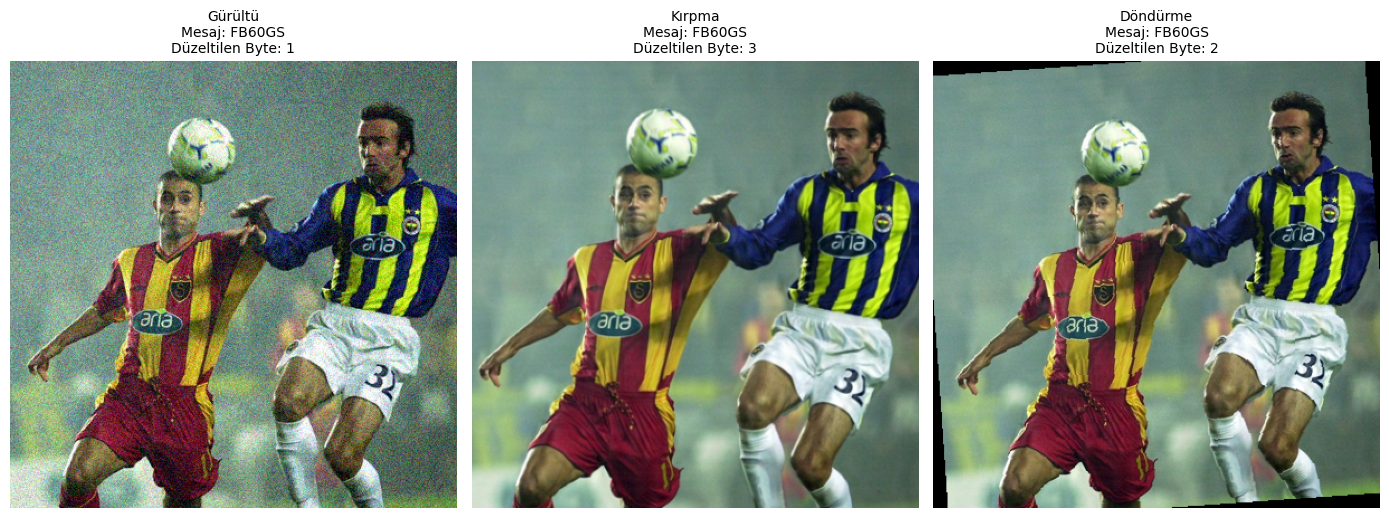

In [ ]:
# @title 8. RSS'li MAIN ÇALIŞTIRMA

IMAGE_FILE = "takim.jpg"
MESSAGE_SHORT = "FB60GS"

# --- SALDIRI PARAMETRELERİ ---
attack_variables = {
    'noise_std': 0.08,
    'crop_scale': 0.95,
    'rot_angle': 4
}

print(f"Test Mesajı: '{MESSAGE_SHORT}'")
print("-" * 30)

# Fonksiyonu çalıştır
run_steganography_with_rs(
    IMAGE_FILE,
    MESSAGE_SHORT,
    encoder,
    decoder,
    lpips_fn,
    attack_params=attack_variables
)

=== HİBRİT SALDIRI TESTİ (Metin Odaklı) ===

Hedef Mesaj: 'FB6GS0'
Saldırı    : Gürültü (std=0.02) + Kırpma (scale=0.95)

✅ Mesaj resme gizlendi.
⚡ Hibrit saldırı uygulandı (Noise + Crop).

----------------------------------------
❌ DURUM 1: RS KORUMASI YOK (Ham Veri)
----------------------------------------
   Beklenen : FB6GS0
   Okunan   : F@6GS0...
   Doğruluk : %83.3
   Durum    : Metin bozuldu, anlamsız karakterler oluştu.

----------------------------------------
✅ DURUM 2: RS KORUMASI AKTİF
----------------------------------------
   Beklenen : FB6GS0
   Okunan   : FB6GS0
   Sonuç    : BAŞARILI (2 Byte düzeltildi) 🏆


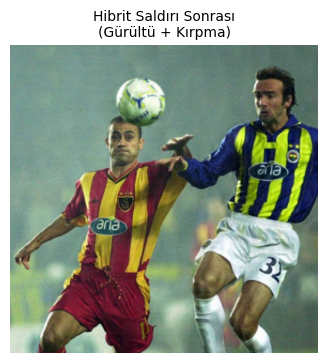

In [ ]:
# @title 9. Hibrit Saldırı Testi
import numpy as np

# --- AYARLAR ---
IMAGE_FILE = "takim.jpg"
SECRET_TEXT = "FB6GS0"
NOISE_STD = 0.02
CROP_SCALE = 0.95

def apply_hybrid_attack(img_tensor, noise, crop):
    # 1. Gürültü
    noisy_img = attack_noise(img_tensor, std=noise)
    # 2. Kırpma
    final_img = attack_crop(noisy_img, scale=crop)
    return final_img

def raw_bits_to_string(bits):
    chars = []
    for i in range(0, 96, 8):
        byte_chunk = bits[i:i+8]
        if len(byte_chunk) == 8:
            val = int("".join(map(str, byte_chunk)), 2)
            if 32 <= val <= 126: #ASCII araligi
                chars.append(chr(val))
            else:
                chars.append('?')
    return "".join(chars)

print(f"=== HİBRİT SALDIRI TESTİ (Metin Odaklı) ===\n")
print(f"Hedef Mesaj: '{SECRET_TEXT}'")
print(f"Saldırı    : Gürültü (std={NOISE_STD}) + Kırpma (scale={CROP_SCALE})\n")

if os.path.exists(IMAGE_FILE):
    # 1. GİZLEME
    original_pil, original_tensor = prepare_image(IMAGE_FILE)
    secret_tensor, secret_bits_in = encode_message_with_rs(SECRET_TEXT)
    residual = encoder((secret_tensor, original_tensor))
    stego_tensor = (original_tensor + residual).clamp(0, 1)

    print("✅ Mesaj resme gizlendi.")

    # 2. SALDIRI
    attacked_tensor = apply_hybrid_attack(stego_tensor, NOISE_STD, CROP_SCALE)
    print("⚡ Hibrit saldırı uygulandı (Noise + Crop).")

    # 3. ÇÖZME
    decoded_raw = decoder(attacked_tensor)

    # --- Analiz, RS'SİZ ---
    clean_pred = decoded_raw.cpu().detach().numpy()[0]
    decoded_bits_raw = np.round(clean_pred).astype(int).tolist()
    raw_text = raw_bits_to_string(decoded_bits_raw)

    # Doğruluk Hesabı
    match_count = sum([1 for a, b in zip(SECRET_TEXT, raw_text) if a == b])
    acc_raw = (match_count / len(SECRET_TEXT)) * 100 if len(SECRET_TEXT) > 0 else 0

    print("\n" + "-"*40)
    print("❌ DURUM 1: RS KORUMASI YOK (Ham Veri)")
    print("-" * 40)
    print(f"   Beklenen : {SECRET_TEXT}")
    print(f"   Okunan   : {raw_text[:len(SECRET_TEXT)]}...") # İlk n karakteri göster
    print(f"   Doğruluk : %{acc_raw:.1f}")
    print(f"   Durum    : Metin bozuldu, anlamsız karakterler oluştu.")

    # --- Analiz, RS'li---
    recovered_msg, flips = decode_message_with_rs(decoded_raw)

    print("\n" + "-"*40)
    print("✅ DURUM 2: RS KORUMASI AKTİF")
    print("-" * 40)
    print(f"   Beklenen : {SECRET_TEXT}")
    print(f"   Okunan   : {recovered_msg}")

    if flips != -1:
        print(f"   Sonuç    : BAŞARILI ({flips} Byte düzeltildi) 🏆")
    else:
        print(f"   Sonuç    : BAŞARISIZ (Kapasite aşıldı) ⚠️")
        print("   -> Saldırı çok ağır geldi, parametreleri düşürmeyi deneyin.")

    # --- GÖRSELLEŞTİRME ---
    attacked_np = attacked_tensor.squeeze().cpu().permute(1, 2, 0).detach().numpy()

    plt.figure(figsize=(4, 4))
    plt.imshow(attacked_np)
    plt.title(f"Hibrit Saldırı Sonrası\n(Gürültü + Kırpma)", fontsize=10)
    plt.axis('off')
    plt.show()

else:
    print("HATA: Resim dosyası bulunamadı.")

=== SES GİZLEME İŞLEMİ ===

----------------------------------------
1. ORİJİNAL MELODİ (Gizlenecek Veri)
   Veri: CDEFG



GÖRSELLER


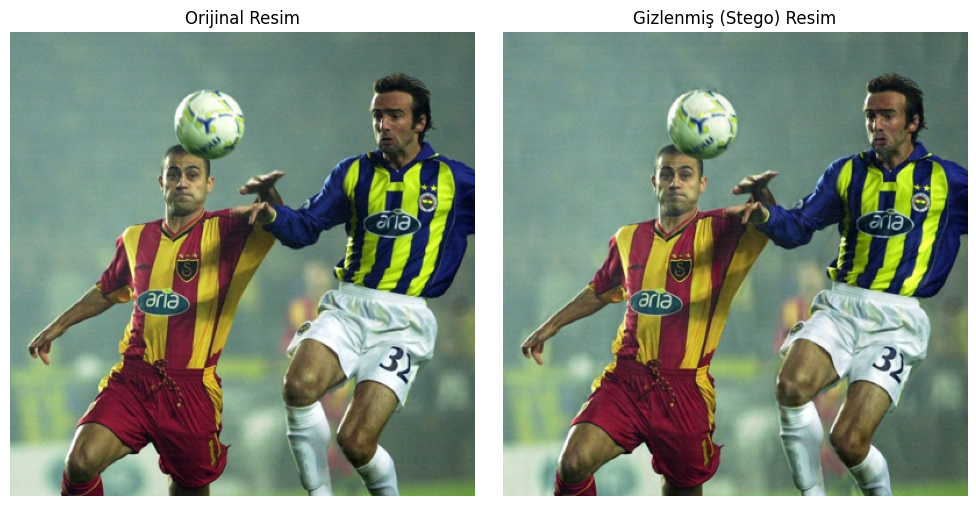

----------------------------------------
🔊 2. GİZLENMİŞ MELODİ ÇIKARTIMI (Saldırı Yok)
   Çıkan Veri: CDEFG (Durum: Temiz)



SALDIRI UYGULANIYOR: Gürültü (Std=0.06) ⚡

3. SALDIRIYA UĞRAMIŞ MELODİ (RS Yok - Bozuk)
   Çıkan Veri (Bozuk): SDEFG
   (Melodideki bozulmaları dinleyin...)



4. RS'Lİ SALDIRIYA UĞRAMIŞ ÇIKTI (Düzeltilmiş)
   Çıkan Veri (Onarılmış): CDEFG
   🛠️ Reed-Solomon Başarısı: 3 Byte düzeltildi!


----------------------------------------


In [ ]:
# @title 10. SES GİZLEME
from IPython.display import Audio, display
import time

# --- AYARLAR ---
IMAGE_FILE = "takim.jpg"
HIDDEN_MELODY = "CDEFG"  # Gizlenecek Melodi: Do Re Mi Fa Sol
NOISE_LEVEL = 0.06      #0.07 / 0.08

# --- FONKSİYONLAR ---
def create_melody_audio(text):
    notes = {'C': 261.63, 'D': 293.66, 'E': 329.63, 'F': 349.23, 'G': 392.00, 'A': 440.00, 'B': 493.88, ' ': 0.0} #harf ve ses frekansi eslestirmesi
    melody_wave = np.array([], dtype=np.float32); rate = 44100; duration = 0.5
    found = False
    for char in text.upper():
        if char in notes:
            found = True; freq = notes[char]; t = np.linspace(0, duration, int(rate * duration), False)
            envelope = np.concatenate([np.linspace(0, 1, 1000), np.ones(int(rate*duration)-2000), np.linspace(1, 0, 1000)])
            wave = np.sin(freq * t * 2 * np.pi) * 0.5 * envelope
            melody_wave = np.concatenate((melody_wave, wave))
        else: # Bozuk karakter için kısa sessizlik
            t = np.linspace(0, 0.1, int(rate * 0.1), False)
            melody_wave = np.concatenate((melody_wave, np.zeros_like(t)))
    return Audio(melody_wave, rate=rate, autoplay=False) if found else None

def raw_bits_to_text(bits, length_chars):
    chars = []
    for i in range(0, length_chars * 8, 8):
        if i+8 <= len(bits):
            val = int("".join(map(str, bits[i:i+8])), 2)
            chars.append(chr(val) if 32 <= val <= 126 else '?')
    return "".join(chars)

print(f"=== SES GİZLEME İŞLEMİ ===\n")
if not os.path.exists(IMAGE_FILE):
    print("HATA: Resim dosyası bulunamadı.")
else:
    # --- HAZIRLIK ---
    original_pil, original_tensor = prepare_image(IMAGE_FILE)
    # RS ile kodlame ve gizleme
    secret_tensor, secret_bits_in = encode_message_with_rs(HIDDEN_MELODY)
    residual = encoder((secret_tensor, original_tensor))
    stego_tensor = (original_tensor + residual).clamp(0, 1)

    print("-" * 40)
    print("1. ORİJİNAL MELODİ (Gizlenecek Veri)")
    print(f"   Veri: {HIDDEN_MELODY}")
    display(create_melody_audio(HIDDEN_MELODY))

    print("\nGÖRSELLER")
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    orig_np = original_tensor.squeeze().cpu().permute(1, 2, 0).detach().numpy()
    stego_np = stego_tensor.squeeze().cpu().permute(1, 2, 0).detach().numpy()
    ax[0].imshow(orig_np); ax[0].set_title("Orijinal Resim"); ax[0].axis('off')
    ax[1].imshow(stego_np); ax[1].set_title("Gizlenmiş (Stego) Resim"); ax[1].axis('off')
    plt.tight_layout(); plt.show()

    # --- ÇIKARMA İŞLEMİ ---
    print("-" * 40)
    print("2. GİZLENMİŞ MELODİ ÇIKARTIMI (Saldırı Yok)")
    decoded_raw_clean = decoder(stego_tensor)
    decoded_msg_clean, flips_clean = decode_message_with_rs(decoded_raw_clean)
    print(f"   Çıkan Veri: {decoded_msg_clean} (Durum: {flips_clean if flips_clean==-1 else 'Temiz'})")
    display(create_melody_audio(decoded_msg_clean))

    # --- SALDIRI---
    print("\n" + "="*40)
    print(f"SALDIRI UYGULANIYOR: Gürültü (Std={NOISE_LEVEL})")
    attacked_tensor = attack_noise(stego_tensor, std=NOISE_LEVEL)
    decoded_raw_attacked = decoder(attacked_tensor)

    clean_pred = decoded_raw_attacked.cpu().detach().numpy()[0]
    decoded_bits_raw = np.round(clean_pred).astype(int).tolist()

    # --- RS'SİZ---
    print("\n3. SALDIRIYA UĞRAMIŞ MELODİ (RS Yok - Bozuk)")
    garbled_text = raw_bits_to_text(decoded_bits_raw, len(HIDDEN_MELODY))
    print(f"   Çıkan Veri (Bozuk): {garbled_text}")
    print("   (Melodideki bozulmaları dinleyin...)")
    audio_garbled = create_melody_audio(garbled_text)
    if audio_garbled: display(audio_garbled)

    # --- RS'Lİ---
    print("\n4. RS'Lİ SALDIRIYA UĞRAMIŞ ÇIKTI (Düzeltilmiş)")
    decoded_msg_rs, flips_rs = decode_message_with_rs(decoded_raw_attacked)

    if flips_rs != -1:
        print(f"   Çıkan Veri (Onarılmış): {decoded_msg_rs}")
        print(f"   🛠️ Reed-Solomon Başarısı: {flips_rs} Byte düzeltildi!")
        display(create_melody_audio(decoded_msg_rs))
    else:
        print(f"   RS Başarısız: Kapasite aşıldı, melodi kurtarılamadı.")
    print("-" * 40)

In [ ]:
# @title 11. Dış Resmi Çözme
import os

EXTERNAL_IMAGE = "2_hidden.jpg"

# === ÇÖZME İŞLEMİ ===
print(f"=== HARİCİ ÇÖZÜlECEK RESİM: {EXTERNAL_IMAGE} ===\n")

if os.path.exists(EXTERNAL_IMAGE):
    _, img_tensor = prepare_image(EXTERNAL_IMAGE)

    decoded_output = decoder(img_tensor)

    raw_msg = decode_raw_string(decoded_output)
    print(f"   Çıkan Metin: {raw_msg}")

=== HARİCİ ÇÖZÜlECEK RESİM: 2_hidden.jpg ===

   Çıkan Metin: pengsenk?a\?


In [ ]:
def decode_raw_string(decoded_tensor):
    clean_pred = decoded_tensor.cpu().detach().numpy()[0]
    bits = np.round(clean_pred).astype(int).tolist()

    chars = []
    for i in range(0, 96, 8):
        byte = bits[i:i+8]
        if len(byte) == 8:
            val = int("".join(map(str, byte)), 2)
            if 32 <= val <= 126:
                chars.append(chr(val))
            else:
                chars.append('?')
    return "".join(chars)